In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib import ticker, transforms
from collections import OrderedDict

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams

from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC
from Utilities.AncillaryFunctions import compute_snr, GenConArangeSimple, scale_and_normalize

from Models.Caller import *
from Benchmarks.Models.BenchmarkCaller import ModelCall as BMCaller

from Benchmarks.Models.DiffWave import DiffWAVE_Restoration, determine_gen_steps_diffwave
from Benchmarks.Models.VDiffWave import VDiffWAVE_Restoration, determine_gen_steps_vdwave


In [2]:
def CustomLinspace(start, end, breakpoints, numbers):
    """
    Generate a series of points within specified intervals and number of points.

    Parameters:
    start (float): The starting value of the sequence.
    end (float): The end value of the sequence.
    breakpoints (list): A list of points where the intervals change.
    numbers (list): A list of integers indicating the number of points in each interval.

    Returns:
    np.array: An array of points including the start, end, and the specified number of points in each interval.
    """

    # Validate input: there should be one more number than there are breakpoints
    if len(breakpoints) + 1 != len(numbers):
        raise ValueError("There must be one more element in 'numbers' than there are in 'breakpoints'.")

    # Combine the start, breakpoints, and end into a single list of points
    points = [start] + breakpoints + [end]
    
    # Initialize an empty array to hold the result
    result = np.array([])

    # Generate points for each interval
    for i in range(len(numbers)):
        # Determine if the endpoint should be included
        endpoint = True if i == len(numbers) - 1 else False  # Include endpoint only for the last interval
        
        # Generate 'numbers[i]' points between 'points[i]' and 'points[i + 1]'
        part = np.linspace(points[i], points[i + 1], numbers[i], endpoint=endpoint)
        result = np.concatenate((result, part))  # Append the new points to the result

    return result


def SigGen (ConfigName, YamlPath, SelIDX= 1, N_Gen = 300, MinFreqR=0.0, MaxFreqR=0.05, GenBP=None, N_GenList = None):
    
    if N_GenList is not None:
            N_Gen = np.sum(N_GenList)
        
        
    EvalConfigs = ReadYaml(YamlPath)
    
    # Loading the model configurations
    if 'SKZFC' in ConfigName:
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)
        # Loading parameters for the evaluation
        Params = LoadParams(ModelConfigSet, EvalConfigs['Parameters'])
        Params['Common_Info'] = EvalConfigs['Common_Info']
        
        # Loading data
        TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float32')
        VallData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')

    elif 'VAE' in ConfigName:
        
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False, TypeDesig = True, RootDirYaml='./Benchmarks/Config/')
        # Loading parameters for the evaluation
        CommonParams = EvalConfigs['Common_Param']
        ModelParams = EvalConfigs["Models"][ConfigName]
        Params = LoadParams(ModelConfigSet, {**CommonParams, **ModelParams})
        Params['Common_Info'] = EvalConfigs['Common_Info']
    
        # Loading data
        TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float32')
        VallData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')

    elif 'DiffWave' in ConfigName or 'VDWave' in ConfigName:
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False, TypeDesig = True, RootDirYaml='./Benchmarks/Config/')
        # Loading parameters for the evaluation
        CommonParams = EvalConfigs['Common_Param']
        ModelParams = EvalConfigs["Models"][ConfigName]
        Params = LoadParams(ModelConfigSet, {**CommonParams, **ModelParams})
        Params['Common_Info'] = EvalConfigs['Common_Info']

        TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float32')
        VallData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')
        SigMax = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'SigMax.pkl', allow_pickle=True)
        SigMin = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'SigMin.pkl', allow_pickle=True)
        
        TrDeNorm = (TrData * (SigMax[Params['SigType']] - SigMin[Params['SigType']]) + SigMin[Params['SigType']]).copy()
        ValDeNorm = (VallData * (SigMax[Params['SigType']] - SigMin[Params['SigType']]) + SigMin[Params['SigType']]).copy()
        
        MeanSig, SigmaSig = np.mean(TrDeNorm), np.std(TrDeNorm) 
        TrInp = (TrDeNorm-MeanSig)/SigmaSig
        ValInp = (ValDeNorm-MeanSig)/SigmaSig

    
    # Intermediate parameters 
    SigDim = VallData.shape[1]
    DataSize = VallData.shape[0]
    Params['DataSize'] = Params['EvalDataSize']


    if 'SKZFC' in ConfigName :

        # Calling Modesl
        SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)
        
        # Setting Model Specifications and Sub-models
        if Params['LossType'] =='Default':
            EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
        elif Params['LossType'] =='FACLosses':
            EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts
    
        NeachFC = len(FeatExtModel.output)
        NCommonFC = EncModel.output[1].shape[1] - NeachFC

        if N_GenList is not None:
            FC_Each = np.tile(CustomLinspace(MinFreqR, MaxFreqR, GenBP, N_GenList)[:, None], (1,NeachFC))
            if NCommonFC==0:
                FC_Comm = np.empty((FC_Each.shape[0],0))
            else:
                FC_Comm = np.tile(CustomLinspace(MinFreqR, MaxFreqR, GenBP, N_GenList)[:, None], (1,NCommonFC))    
        else:
            FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,NeachFC))
            if NCommonFC==0:
                FC_Comm = np.empty((FC_Each.shape[0],0))
            else:
                FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,NCommonFC))

        
        ## The generation model for evaluation
        RecOut = ReconModel(FeatGenModel.output)
        GenModel = Model(FeatGenModel.input, RecOut)
        
        ## The sampling model for evaluation
        Zs_Out = SigRepModel.get_layer('Zs').output
        SampModel = Model(EncModel.input, Zs_Out)
    
        # Signal generation
        AnalData = VallData
        OrginalSig = AnalData[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampModel.predict(InpSignal)

        FeatGen = FeatGenModel([FC_Comm,FC_Each, PredZs])
        ReconSignal = ReconModel.predict([FeatGen])
        CON_Arange = None
        
    
    elif 'VAE' in ConfigName:
    
        # Calling Modesl
        BenchModel, _, AnalData = BMCaller (Params, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:])

        ## The generation model for evaluation
        GenModel = BenchModel.get_layer('ReconModel')

        ## The sampling model for evaluation
        Inp_Enc = BenchModel.get_layer('Inp_Enc')
        
        if 'VDV' in ConfigName:
            Zs = tf.concat([BenchModel.get_layer('Zs'+str(i)).output for i in range(len(Params['LatDim']))], axis=-1)
        else:
            Zs = BenchModel.get_layer('Zs').output
            
        Inp_Cond = BenchModel.get_layer('Inp_Cond')
        SampZModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)

        # Signal generation
        RawSignal, ConData = AnalData
        CON_Arange = GenConArangeSimple(ConData, N_Gen)
        OrginalSig = RawSignal[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampZModel.predict([InpSignal, CON_Arange])
        ReconSignal = GenModel.predict([PredZs, CON_Arange])
    
    
    elif 'DiffWave' in ConfigName or 'VDWave' in ConfigName:
        
        # Calling Modesl
        GenModel, _, AnalData = BMCaller (Params, ConfigName, TrInp, ValInp, LoadWeight = True, ModelSaveName='./Benchmarks/' + ModelLoadName[2:])  

        RawSignal, ConData = AnalData
        CON_Arange = GenConArangeSimple(ConData, N_Gen)

        OrginalSig = RawSignal[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)

        if 'DiffWave' in ConfigName:
            # Perform diffusion with determined steps and restore the signal
            GenSteps, noise = determine_gen_steps_diffwave(InpSignal, GenModel, Params['Iter'], Params['GaussSigma'], Params['SNR_cutoff'])
            diffused, _ = GenModel.diffusion(InpSignal, GenModel.alpha_bar[GenSteps].item(), noise)
            GenSig = DiffWAVE_Restoration(GenModel, diffused, CON_Arange,  GenBatchSize=1000, GenSteps=GenSteps, StepInterval=Params['StepInterval'])
        elif 'VDWave' in ConfigName:
            GenSteps, t_float, noise = determine_gen_steps_vdwave(InpSignal, GenModel, Params['Iter'], Params['SNR_cutoff'])
            diffused, _, noise = GenModel.sample_q_t_0(InpSignal, t_float, None, gamma_t=None)
            GenSig = VDiffWAVE_Restoration(GenModel, diffused[0][..., None], CON_Arange,  GenSteps, GenModel.cfg['StepInterval'], GenBatchSize=Params['GenBatchSize'])            
       
        # Scale and normalize the restored signal and ground truth
        ReconSignal = scale_and_normalize(np.squeeze(GenSig), SigmaSig, MeanSig, SigMin[Params['SigType']], SigMax[Params['SigType']])
        OrginalSig = scale_and_normalize(OrginalSig, SigmaSig, MeanSig, SigMin[Params['SigType']], SigMax[Params['SigType']])
        PredZs = None

    HalfLen = ReconSignal.shape[1]//2
    FFTRes = np.abs(np.fft.fft(ReconSignal, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen

    return ReconSignal, Amplitude, OrginalSig, PredZs, CON_Arange
    

In [3]:

DicConfigYaml = { 
    'ART_VitalDB' : {'SKZFC_ART_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                     'VDWave_ART_VitalDB':   './Benchmarks/Config/EvalConfigART_Other.yml', 
                     'VDVAE_ART_30_VitalDB':   './Benchmarks/Config/EvalConfigART_VAE.yml'},
   
    'ART_Mimic' : {'SKZFC_ART_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     'VDWave_ART_Mimic':   './Benchmarks/Config/EvalConfigART_Other.yml', 
                     'VDVAE_ART_30_Mimic':   './Benchmarks/Config/EvalConfigART_VAE.yml'},
    
    'II_VitalDB' : {'SKZFC_II_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                     'VDWave_II_VitalDB':   './Benchmarks/Config/EvalConfigII_Other.yml', 
                     'VDVAE_II_30_VitalDB':   './Benchmarks/Config/EvalConfigII_VAE.yml'},
    
    'II_Mimic' : {'SKZFC_II_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     'VDWave_II_Mimic':   './Benchmarks/Config/EvalConfigII_Other.yml', 
                     'VDVAE_II_30_Mimic':   './Benchmarks/Config/EvalConfigII_VAE.yml'}    }

'''
DicConfigYaml = { 
    'ART_VitalDB' : {'SKZFC_ART_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
},
   
    'ART_Mimic' : {'SKZFC_ART_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     },
    
    'II_VitalDB' : {'SKZFC_II_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                    },
    
    'II_Mimic' : {'SKZFC_II_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                    }    }

'''



MinFreq=1
MaxFreq=50

DicParam = {'ART_VitalDB': 
                         {'SelIDX' : 13, 
                          'MinFreqR':0.0015, 
                          'MaxFreqR':0.9, 
                          'GenBP':[0.02, 0.1],
                          'N_GenList':[500, 50, 50] },
            'ART_Mimic': 
                         {'SelIDX' : 28, 
                          'MinFreqR':0.00, 
                          'MaxFreqR':0.9, 
                          'GenBP':[0.01, 0.02], 
                          'N_GenList':[400, 150, 50] },
            'II_VitalDB': 
                         {'SelIDX' : 30, 
                          'MinFreqR':0.01, 
                          'MaxFreqR':0.7, 
                          'GenBP':[0.1, 0.5], 
                          'N_GenList':[500, 50, 50] },
            'II_Mimic': 
                         {'SelIDX' : 1, 
                          'MinFreqR':0.001, 
                          'MaxFreqR':0.99, 
                          'GenBP':[0.05, 0.1], 
                          'N_GenList':[500, 50, 50] }
           }





GeneratedSignals = {}
GeneratedAmplitude = {}
InpSignals = {}
Zs = {}
CON_Aranges = {}

GeneratedSignals = {}
GeneratedAmplitude = {}
InpSignals = {}
Zs = {}
CON_Aranges = {}

for ConfigYaml in DicConfigYaml.items():
    SelIDX, MinFreqR, MaxFreqR,GenBP, N_GenList = DicParam[ConfigYaml[0]].values()
    for ConfigName in ConfigYaml[1]:
        print(ConfigName)
        ReconSignal, Amplitude, InpSignal, PredZs, CON_Arange = SigGen(ConfigName, ConfigYaml[1][ConfigName], SelIDX= SelIDX, 
                                                                       N_Gen = np.sum(N_GenList), MinFreqR=MinFreqR, MaxFreqR=MaxFreqR,  GenBP=GenBP, N_GenList=N_GenList) #56
        GeneratedSignals[ConfigName] = ReconSignal
        GeneratedAmplitude[ConfigName] = Amplitude
        InpSignals[ConfigName] = InpSignal
        Zs[ConfigName] = PredZs
        CON_Aranges[ConfigName] = CON_Arange

SKZFC_ART_1_30_800_VitalDB
OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 50)      11550       ['bidirecti

[Restoration] Processing Steps: 100%|█████████████████████████████████| 36/36 [01:10<00:00,  1.97s/it, Current Step=71]


VDVAE_ART_30_VitalDB
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_3 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_3[0][0]']      
 l)                                                                                               
                                                                                                  
 bidirectional_15 (Bidirectiona  (None, 20, 50)      11550       ['bidi

[Restoration] Processing Steps: 100%|█████████████████████████████████| 37/37 [00:43<00:00,  1.17s/it, Current Step=73]


VDVAE_ART_30_Mimic
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_7 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_46 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_7[0][0]']      
 l)                                                                                               
                                                                                                  
 bidirectional_47 (Bidirectiona  (None, 20, 50)      11550       ['bidire

[Restoration] Processing Steps: 100%|█████████████████████████████████| 42/42 [01:20<00:00,  1.91s/it, Current Step=83]


VDVAE_II_30_VitalDB
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_11 (TFOpLambda  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_78 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_11[0][0]']     
 l)                                                                                               
                                                                       

[Restoration] Processing Steps: 100%|█████████████████████████████████| 42/42 [02:00<00:00,  2.87s/it, Current Step=83]


VDVAE_II_30_Mimic
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_15 (TFOpLambda  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_110 (Bidirection  (None, 20, 50)      11550       ['tf.signal.frame_15[0][0]']     
 al)                                                                                              
                                                                         

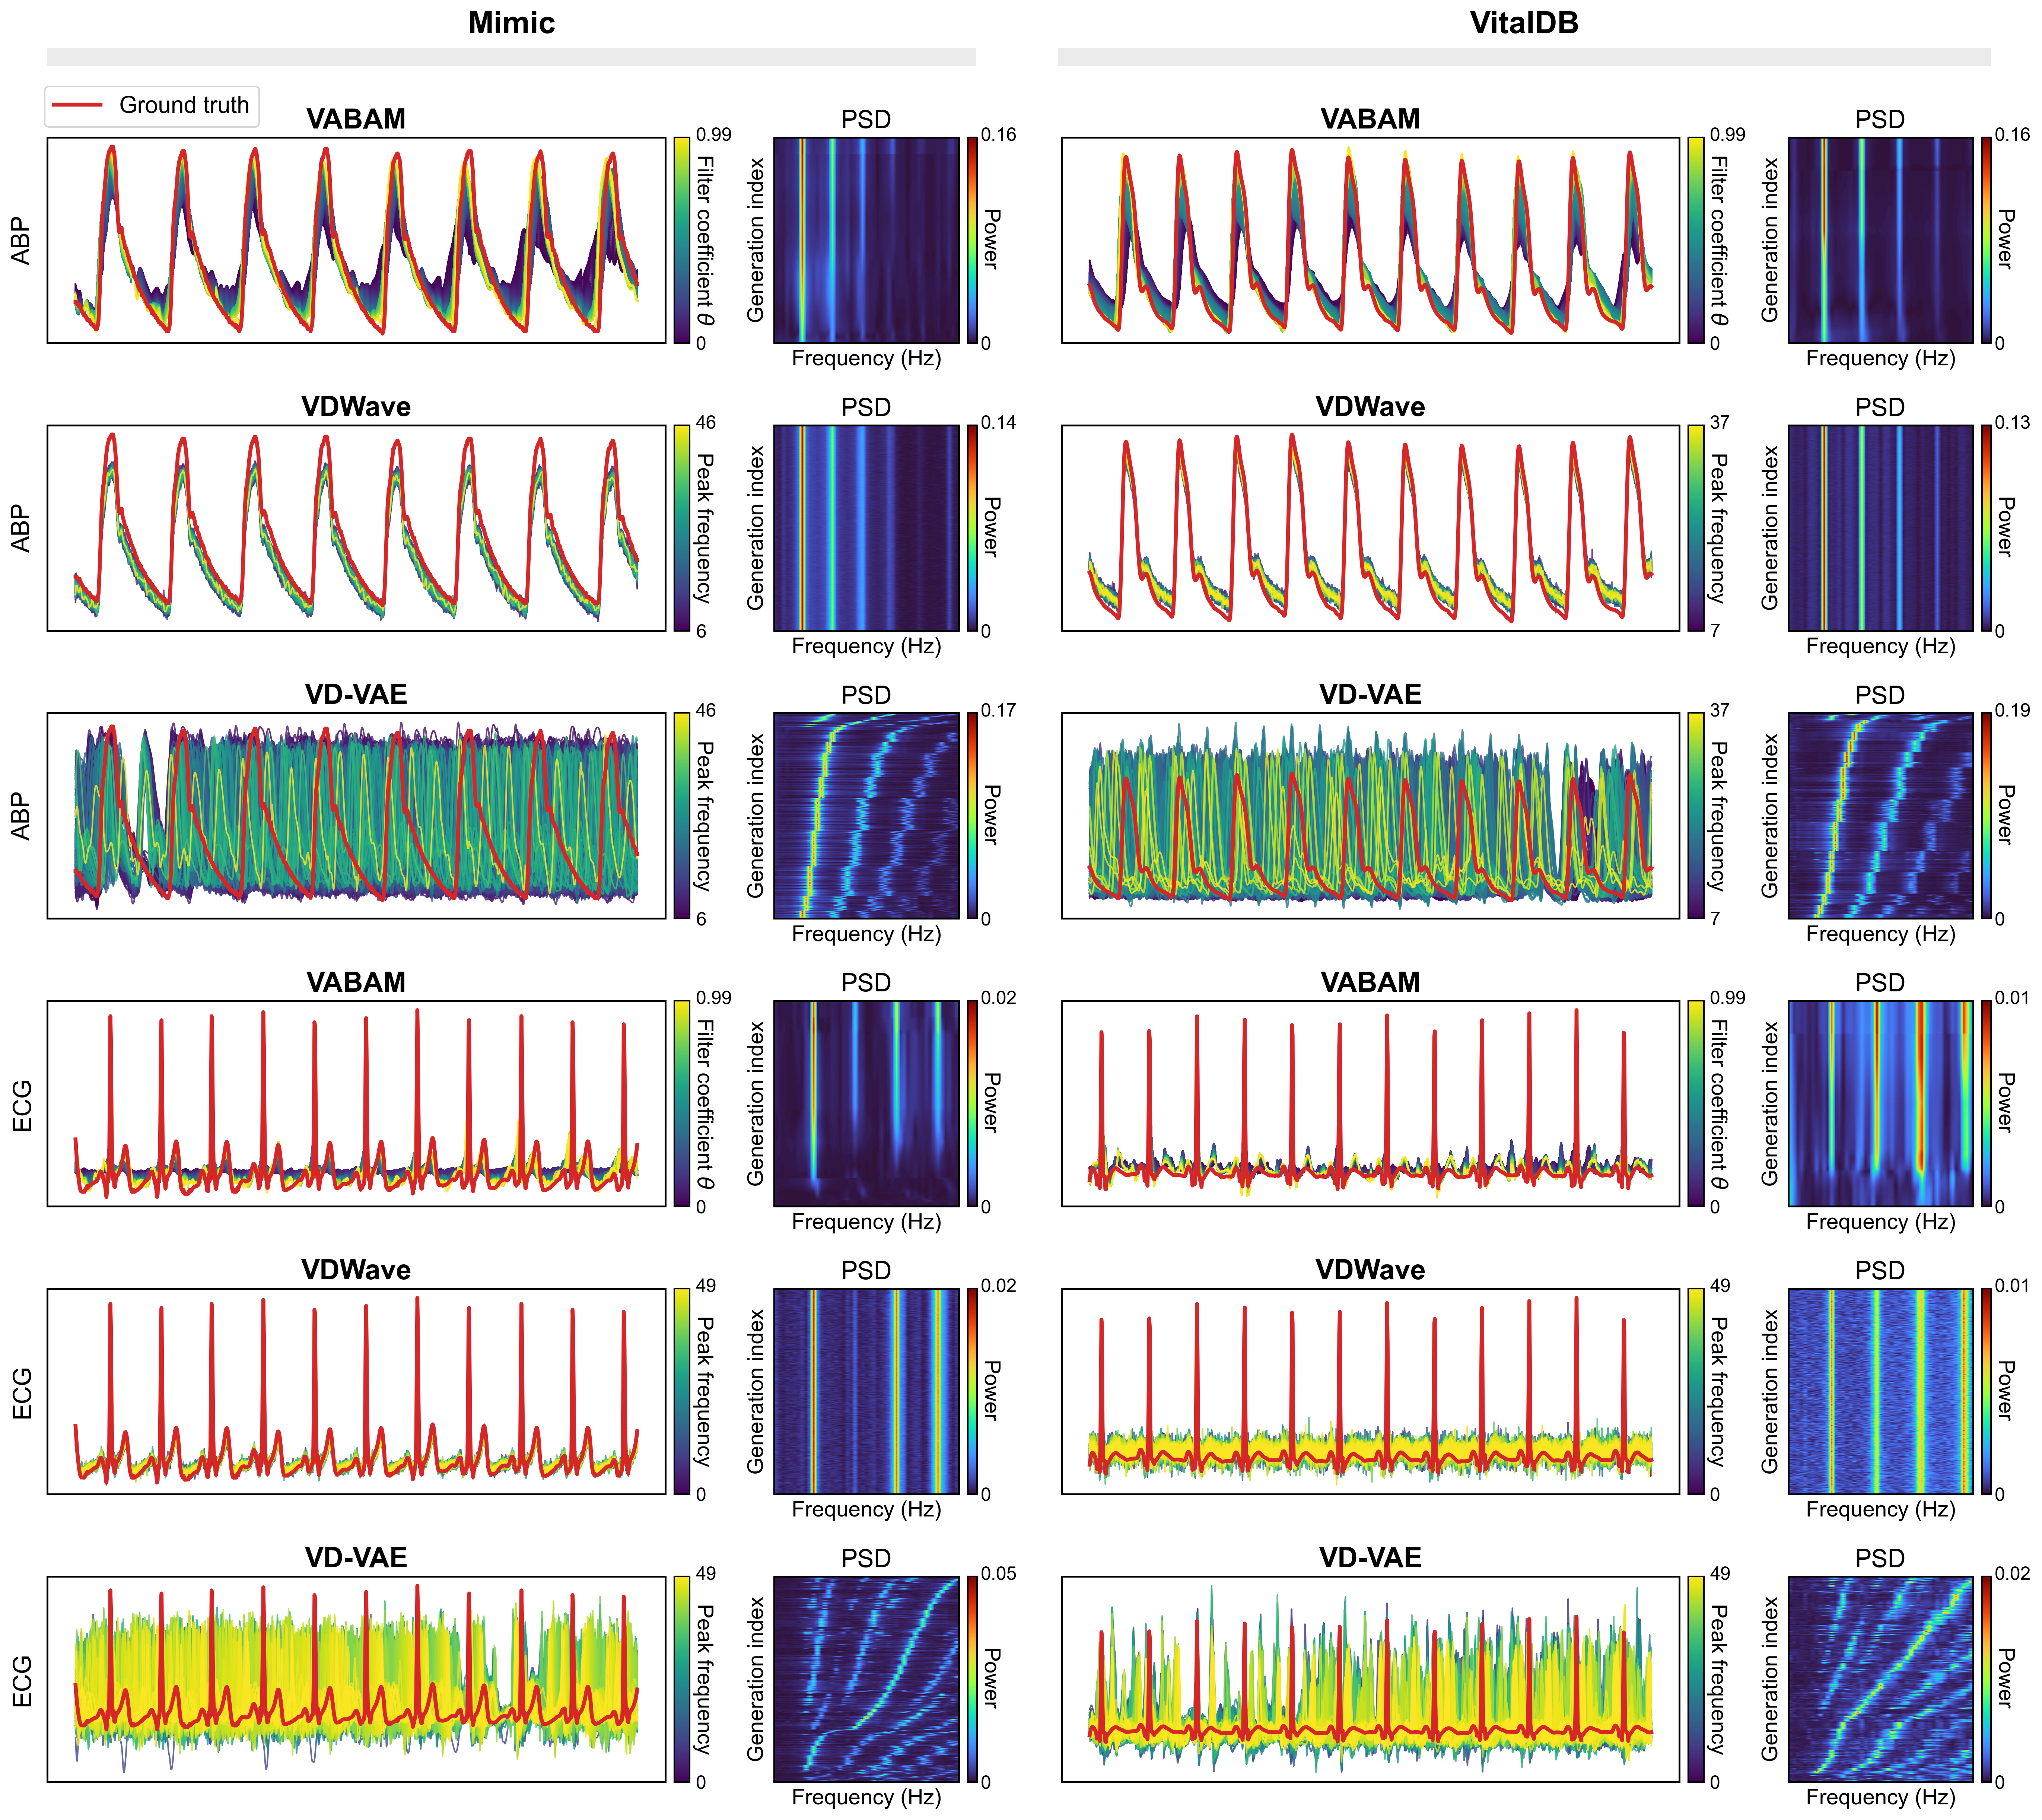

In [4]:
# -*- coding: utf-8 -*-
# =========================
# Figure-wide style (Nature-ish, full spines)
# =========================
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2,
    "figure.dpi": 300,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
})

# =========================
# Assumed globals in the session
# - DicParam, DicConfigYaml, GeneratedSignals, InpSignals
# - GeneratedAmplitude, CON_Aranges, MinFreq, MaxFreq, MinFreqR, MaxFreqR
# =========================
N_Gen = sum(DicParam['ART_VitalDB']['N_GenList'])
keys = [ConfigName[0] for ConfigItems in DicConfigYaml.items() for ConfigName in ConfigItems[1].items()]

# Figure layout: 6 rows × 4 columns (Signal | cbar | Signal | cbar)
n_rows = 6
n_cols = 4

# =========================
# Colormap
# =========================
signal_cmap = plt.get_cmap('viridis')  # for line plots
psd_cmap_name = 'turbo'                 # for PSD heatmaps

# =========================
# Label mappings
# =========================
model_labels = {'SKZFC':'VABAM','ConVAE':'C-VAE','DiffWave':'DiffWave','VDVAE':'VD-VAE','VDWave':'VDWave'}
signal_types = {'ART':'ABP','II':'ECG'}

def _model_label_from_key(k):
    for kk, vv in model_labels.items():
        if kk in k:
            return vv
    return 'Unknown'

def _signal_label_from_key(k):
    for kk, vv in signal_types.items():
        if kk in k:
            return vv
    return 'Signal'

def _source_tag(k):
    if 'VitalDB' in k: return 'VitalDB'
    if 'Mimic' in k or 'MIMIC' in k: return 'MIMIC'
    return ''

# =========================
# Enhanced Colorbar configuration - FIXED VERSION
# =========================
CBAR_CONFIG = {
    "signal": {
        "pos_min": "right", "dx_min": 0.4, "dy_min": -0.05, "dx_min_pt": 0,  "dy_min_pt": 0,
        "pos_max": "right", "dx_max": 0.4, "dy_max": 0.05, "dx_max_pt": 0,  "dy_max_pt": 0,
        "pad": 0.08
    },
    "psd": {
        "pos_min": "right", "dx_min": 0.4, "dy_min": -0.05, "dx_min_pt": 0,  "dy_min_pt": 0,
        "pos_max": "right", "dx_max": 0.4, "dy_max": 0.05, "dx_max_pt": 0,  "dy_max_pt": 0,
        "pad": 0.08
    }
}

# =========================
# Helpers
# =========================
def _format_tick_value(v):
    """Integer-like -> no decimals, else trim trailing zeros."""
    if np.isfinite(v) and abs(v - np.round(v)) < 1e-9:
        return f"{int(np.round(v))}"
    s = f"{v:.2f}".rstrip('0').rstrip('.')
    return s if s else "0"

def _axes_plus_pt(ax, dx_pt=0, dy_pt=0):
    """Return a transform = axes fraction + (dx_pt, dy_pt) in points."""
    return ax.transAxes + transforms.ScaledTranslation(dx_pt/72, dy_pt/72, ax.figure.dpi_scale_trans)

def _place_label(ax, text, pos, dx, dy, dx_pt=0, dy_pt=0, is_min=True, fontsize=13):
    """
    Place label right at the colorbar edge (axes coords) with extra point tweaks.
    For vertical bars ('right'/'left'), x is exactly at 1.0 or 0.0 (bar edge).
    For horizontal ('top'/'bottom'), y is exactly at 1.0 or 0.0.
    """
    if pos in ('right', 'left'):
        y = 0.0 if is_min else 1.0
        x = 1.0 if pos == 'right' else 0.0
        ha = 'left' if pos == 'right' else 'right'
        va = 'bottom' if is_min else 'top'
        trans = _axes_plus_pt(ax, dx_pt=dx_pt, dy_pt=dy_pt)
        ax.text(x + dx, y + dy, text, transform=trans, ha=ha, va=va,
                fontsize=fontsize, clip_on=False, zorder=1000, color='black')
    elif pos == 'top':
        x, y = 0.5, 1.0
        ha, va = 'center', 'bottom'
        trans = _axes_plus_pt(ax, dx_pt=dx_pt, dy_pt=dy_pt)
        ax.text(x + dx, y + dy, text, transform=trans, ha=ha, va=va,
                fontsize=fontsize, clip_on=False, zorder=1000, color='black')
    elif pos == 'bottom':
        x, y = 0.5, 0.0
        ha, va = 'center', 'top'
        trans = _axes_plus_pt(ax, dx_pt=dx_pt, dy_pt=dy_pt)
        ax.text(x + dx, y + dy, text, transform=trans, ha=ha, va=va,
                fontsize=fontsize, clip_on=False, zorder=1000, color='black')
    else:
        # Fallback to 'right'
        _place_label(ax, text, 'right', dx, dy, dx_pt, dy_pt, is_min, fontsize)

def _decorate_cbar_end_labels(
    cbar, vmin, vmax,
    pos_min='right', dx_min=0.00, dy_min=0.00, dx_min_pt=0, dy_min_pt=0,
    pos_max='right', dx_max=0.00, dy_max=0.00, dx_max_pt=0, dy_max_pt=0,
    fontsize=13
):
    """
    Show min/max labels without tick marks.
    """
    # Remove all tick marks but keep the ability to place labels
    cbar.locator   = ticker.FixedLocator([vmin, vmax])
    cbar.formatter = ticker.FixedFormatter(['', ''])  # hide default labels
    cbar.update_ticks()
    cbar.ax.tick_params(which='both', length=0, pad=0)  # Remove tick marks (length=0)

    # Optional: make outline a touch bolder for crisp alignment
    if cbar.outline:
        cbar.outline.set_linewidth(1.0)

    # Place our custom end labels
    _place_label(cbar.ax, _format_tick_value(vmin), pos_min, dx_min, dy_min,
                 dx_min_pt, dy_min_pt, is_min=True, fontsize=fontsize)
    _place_label(cbar.ax, _format_tick_value(vmax), pos_max, dx_max, dy_max,
                 dx_max_pt, dy_max_pt, is_min=False, fontsize=fontsize)

# -------------------------------------------------
# Pair keys by (model_label, signal_label) with order [MIMIC, VitalDB]
# -------------------------------------------------
pairs_dict = OrderedDict()
for k in keys:
    mid = (_model_label_from_key(k), _signal_label_from_key(k))
    src = _source_tag(k)
    if not src: continue
    if mid not in pairs_dict:
        pairs_dict[mid] = {'MIMIC': None, 'VitalDB': None}
    if src == 'MIMIC' and pairs_dict[mid]['MIMIC'] is None:
        pairs_dict[mid]['MIMIC'] = k
    elif src == 'VitalDB' and pairs_dict[mid]['VitalDB'] is None:
        pairs_dict[mid]['VitalDB'] = k

pairs = list(pairs_dict.values())[:n_rows]
while len(pairs) < n_rows:
    pairs.append({'MIMIC': None, 'VitalDB': None})

# =========================
# Figure & GridSpec
# =========================
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(n_rows, n_cols, figure=fig,
              width_ratios=[3.8, 1.2, 3.8, 1.2],
              hspace=0.4, wspace=0.2)

gt_handle = None
row_left_sig_axes, row_signal_names = [], []

# =========================
# Render one cell (Signal + PSD) for a given key
# =========================
def _render_cell(row, pos_in_row, key):
    """pos_in_row: 0 => left pair (MIMIC), 1 => right pair (VitalDB)"""
    col_signal = 0 if pos_in_row == 0 else 2
    col_psd = col_signal + 1

    if key is None:
        ax_empty_s = fig.add_subplot(gs[row, col_signal])
        ax_empty_p = fig.add_subplot(gs[row, col_psd])
        for ax in (ax_empty_s, ax_empty_p):
            ax.set_xticks([]); ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_color('black'); spine.set_linewidth(1.2); spine.set_visible(True)
        ax_empty_s.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        ax_empty_p.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        return ax_empty_s, ax_empty_p, None

    model_name  = _model_label_from_key(key)
    signal_name = _signal_label_from_key(key)

    # Color normalization per model type
    if 'SKZFC' in key:
        param_values = np.linspace(MinFreqR, MaxFreqR, N_Gen)
        param_norm   = plt.Normalize(MinFreqR, MaxFreqR)
        param_label  = r'Filter coefficient $\theta$'
    elif any(m in key for m in ['VAE', 'DiffWave', 'VDWave']):
        FreqIDX      = np.argmax(CON_Aranges[key], axis=-1)
        param_values = FreqIDX
        param_norm   = plt.Normalize(np.min(FreqIDX), np.max(FreqIDX))
        param_label  = 'Peak frequency'
    else:
        param_values = np.arange(N_Gen)
        param_norm   = plt.Normalize(0, N_Gen-1)
        param_label  = 'Generation index'

    # ----- Signal plot -----
    ax_signal = fig.add_subplot(gs[row, col_signal])
    for i in range(N_Gen):
        color = signal_cmap(param_norm(param_values[i] if i < len(param_values) else i))
        ax_signal.plot(GeneratedSignals[key][i], color=color, alpha=0.8, linewidth=1.0)

    gt_line, = ax_signal.plot(
        InpSignals[key][0], color='#d62728', linewidth=2.5, label='Ground truth'
    )
    global gt_handle
    if gt_handle is None:
        gt_handle = gt_line

    ax_signal.set_title(model_name, fontweight='bold', fontsize=18)
    ax_signal.set_xticks([]); ax_signal.set_yticks([])
    for spine in ax_signal.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.2); spine.set_visible(True)

    # ----- Signal colorbar -----
    divider1 = make_axes_locatable(ax_signal)
    cax1 = divider1.append_axes("right", size="2.5%", pad=CBAR_CONFIG["signal"]["pad"])
    sm1 = plt.cm.ScalarMappable(cmap=signal_cmap, norm=param_norm); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax1)
    cbar1.set_label(param_label, fontsize=14, rotation=-90, labelpad=15)

    _decorate_cbar_end_labels(
        cbar1, param_norm.vmin, param_norm.vmax,
        pos_min=CBAR_CONFIG["signal"]["pos_min"],
        dx_min=CBAR_CONFIG["signal"]["dx_min"], dy_min=CBAR_CONFIG["signal"]["dy_min"],
        dx_min_pt=CBAR_CONFIG["signal"]["dx_min_pt"], dy_min_pt=CBAR_CONFIG["signal"]["dy_min_pt"],
        pos_max=CBAR_CONFIG["signal"]["pos_max"],
        dx_max=CBAR_CONFIG["signal"]["dx_max"], dy_max=CBAR_CONFIG["signal"]["dy_max"],
        dx_max_pt=CBAR_CONFIG["signal"]["dx_max_pt"], dy_max_pt=CBAR_CONFIG["signal"]["dy_max_pt"],
        fontsize=12
    )

    # ----- PSD heatmap -----
    ax_psd = fig.add_subplot(gs[row, col_psd])
    heatmap_data = GeneratedAmplitude[key][:, MinFreq:MaxFreq]
    im = ax_psd.imshow(
        heatmap_data, cmap=psd_cmap_name, aspect='auto',
        interpolation='bilinear', origin='lower'
    )
    ax_psd.set_title('PSD', fontsize=16)
    ax_psd.set_xticks([]); ax_psd.set_yticks([])
    ax_psd.set_xlabel('Frequency (Hz)', fontsize=14)
    ax_psd.set_ylabel('Generation index', fontsize=14)
    for spine in ax_psd.spines.values():
        spine.set_color('black'); spine.set_linewidth(1.2); spine.set_visible(True)

    # ----- PSD colorbar -----
    divider2 = make_axes_locatable(ax_psd)
    cax2 = divider2.append_axes("right", size="5%", pad=CBAR_CONFIG["psd"]["pad"])
    cbar2 = fig.colorbar(im, cax=cax2)
    cbar2.set_label('Power', fontsize=14, rotation=-90, labelpad=14)
    vmin, vmax = im.norm.vmin, im.norm.vmax

    _decorate_cbar_end_labels(
        cbar2, vmin, vmax,
        pos_min=CBAR_CONFIG["psd"]["pos_min"],
        dx_min=CBAR_CONFIG["psd"]["dx_min"], dy_min=CBAR_CONFIG["psd"]["dy_min"],
        dx_min_pt=CBAR_CONFIG["psd"]["dx_min_pt"], dy_min_pt=CBAR_CONFIG["psd"]["dy_min_pt"],
        pos_max=CBAR_CONFIG["psd"]["pos_max"],
        dx_max=CBAR_CONFIG["psd"]["dx_max"], dy_max=CBAR_CONFIG["psd"]["dy_max"],
        dx_max_pt=CBAR_CONFIG["psd"]["dx_max_pt"], dy_max_pt=CBAR_CONFIG["psd"]["dy_max_pt"],
        fontsize=12
    )

    return ax_signal, ax_psd, signal_name

# =========================
# Render rows (left=MIMIC, right=VitalDB)
# =========================
first_row_left_axes = None
first_row_right_axes = None
row_left_sig_axes, row_signal_names = [], []

for row_idx in range(n_rows):
    pair = pairs[row_idx]
    left_out  = _render_cell(row_idx, 0, pair.get('MIMIC'))
    right_out = _render_cell(row_idx, 1, pair.get('VitalDB'))
    if row_idx == 0:
        first_row_left_axes  = (left_out[0],  left_out[1])
        first_row_right_axes = (right_out[0], right_out[1])
    chosen_signal = (left_out[2] or right_out[2] or 'Signal')
    row_signal_names.append(chosen_signal)
    row_left_sig_axes.append(left_out[0] if left_out[0] is not None else right_out[0])

# =========================
# Global legend
# =========================
if gt_handle is not None:
    fig.legend(handles=[gt_handle], labels=['Ground truth'],
               loc='upper right', bbox_to_anchor=(0.19, 0.995),
               frameon=True, fontsize=15, shadow=False)

# =========================
# Top group headers (MIMIC / VitalDB)
# =========================
if first_row_left_axes is not None and first_row_right_axes is not None:
    left_sig_ax,  left_psd_ax  = first_row_left_axes
    right_sig_ax, right_psd_ax = first_row_right_axes
    left_pos_start  = left_sig_ax.get_position()
    left_pos_end    = left_psd_ax.get_position()
    right_pos_start = right_sig_ax.get_position()
    right_pos_end   = right_psd_ax.get_position()

    group1_x0 = left_pos_start.x0 - 0.035
    group1_x1 = left_pos_end.x1   + 0.01
    group2_x0 = right_pos_start.x0 + 0.013
    group2_x1 = right_pos_end.x1   + 0.06

    top_y = max(left_pos_start.y1, left_pos_end.y1, right_pos_start.y1, right_pos_end.y1) + 0.12
    bar_height = 0.01

    fig.patches.extend([
        Rectangle((group1_x0, top_y), group1_x1 - group1_x0, bar_height,
                  transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0),
        Rectangle((group2_x0, top_y), group2_x1 - group2_x0, bar_height,
                  transform=fig.transFigure, facecolor="#cfcfcf", alpha=0.4, zorder=0)
    ])
    fig.text((group1_x0 + group1_x1)/2, top_y + bar_height + 0.005, "Mimic",
             ha='center', va='bottom', fontsize=20, fontweight='bold')
    fig.text((group2_x0 + group2_x1)/2, top_y + bar_height + 0.005, "VitalDB",
             ha='center', va='bottom', fontsize=20, fontweight='bold')

# =========================
# Vertical left-side labels (ABP / ECG), centered in axis (y=0.5)
# =========================
for ax_left, sig_name in zip(row_left_sig_axes, row_signal_names):
    if ax_left is None:
        continue
    ax_left.text(-0.04, 0.5, sig_name,
                 transform=ax_left.transAxes,
                 rotation=90, va='center', ha='center',
                 fontsize=16, clip_on=False)

# =========================
# Final layout
# =========================
plt.subplots_adjust(top=0.96, bottom=0.04, left=0.09, right=0.96)

'''
For SKZFC, generation is conditioned on the cascading filter coefficient~$\theta$, which directly modulates the signal synthesis process.
For other models, conditioning is provided by the input signal's power spectrum; the dominant frequency bin is extracted for display purposes.
'''
plt.savefig('./PaperWork/Figures/synthesis_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
